In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [27]:
# Load the dataset
df = pd.read_csv("C:\\Project\\Customer_Lifetime_Value_Prediction.csv")

In [28]:
# Data Cleaning & Preprocessing
df['Gender'] = df['Gender'].astype('category')
df['Churned'] = df['Churned'].astype('category')
df['CustomerSegment'] = df['CustomerSegment'].astype('category')

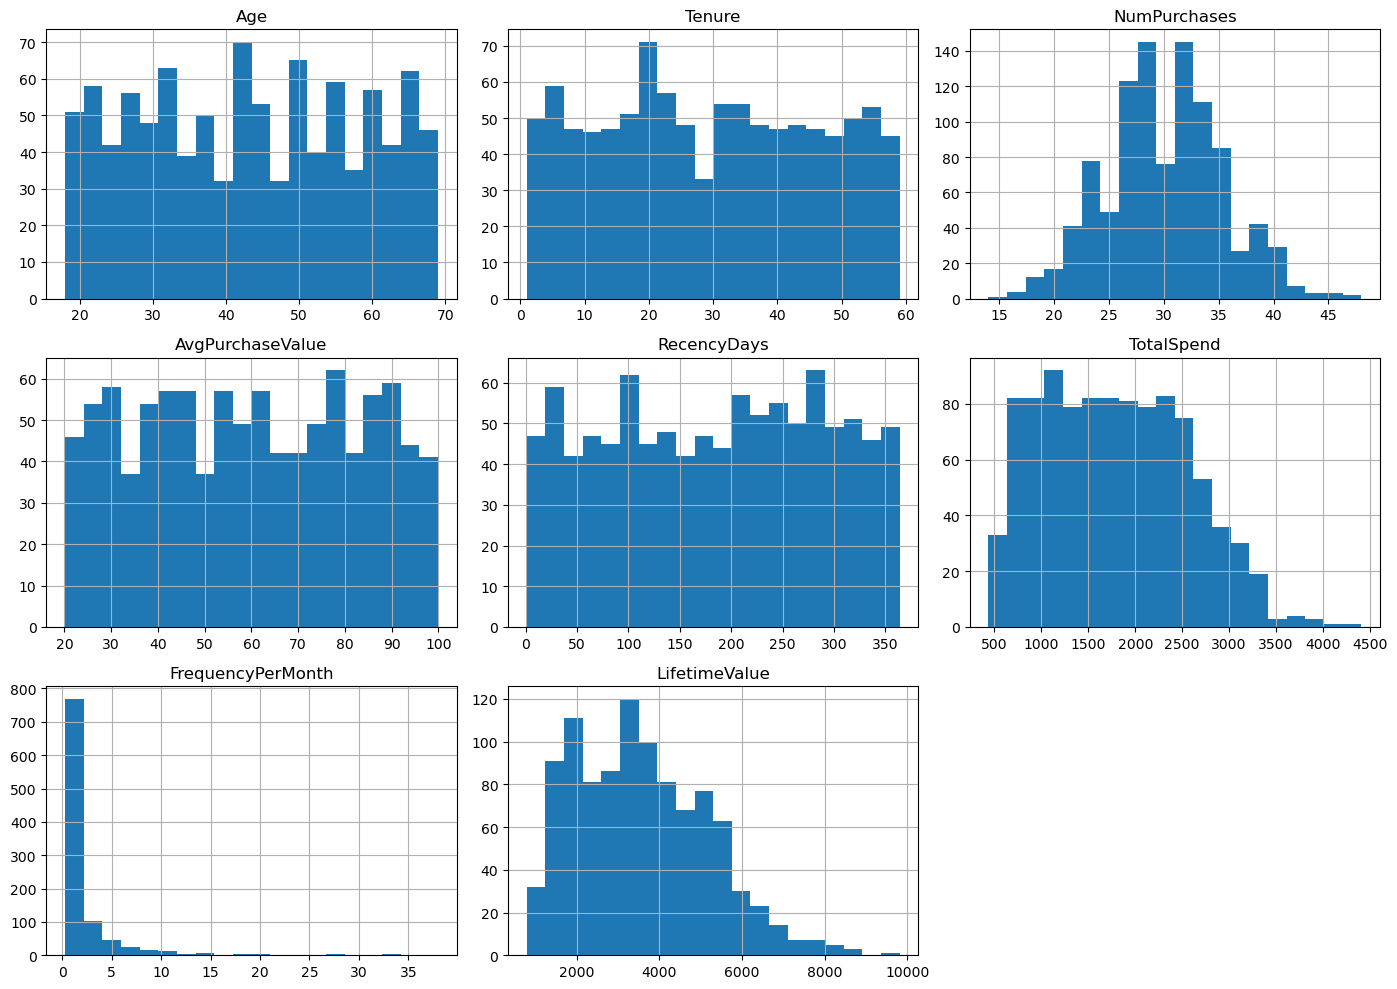

In [29]:
#Exploratory Data Analysis (EDA)
df.select_dtypes(include=[np.number]).hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

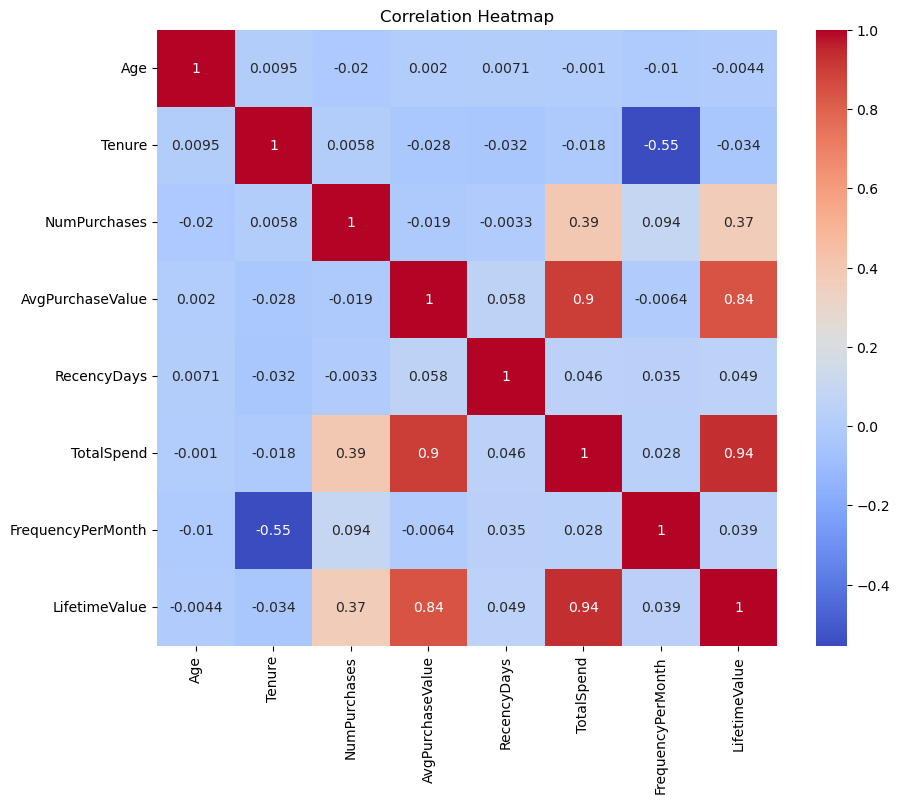

In [30]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [31]:
# Feature Engineering
categorical_cols = ['Gender', 'Churned', 'CustomerSegment']
numeric_cols = ['Age', 'Tenure', 'NumPurchases', 'AvgPurchaseValue',
                'RecencyDays', 'TotalSpend', 'FrequencyPerMonth']
target = 'LifetimeValue'
# Set up column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [32]:
# Prepare features and target
X = df[numeric_cols + categorical_cols]
y = df[target]
X_processed = preprocessor.fit_transform(X)

In [33]:
# Model Training & Evaluation
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [34]:
# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)


In [35]:
# Train XGBoost
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)


In [36]:
# Evaluate models
def evaluate_model(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, xgb_preds, "XGBoost")

Random Forest - MAE: 441.32, RMSE: 556.44
XGBoost - MAE: 487.10, RMSE: 608.87


In [37]:
#Final Prediction & Segmentation
# Predict on full data using best model (Random Forest)
ltv_predictions = rf_model.predict(X_processed)
df['PredictedLTV'] = ltv_predictions

In [38]:
# Segment into Low, Medium, High
df['LTVSegment'] = pd.qcut(df['PredictedLTV'], q=3, labels=['Low', 'Medium', 'High'])

C:\Users\padma\AppData\Local\Temp\ipykernel_13808\1186581576.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='LTVSegment', palette='Set2')


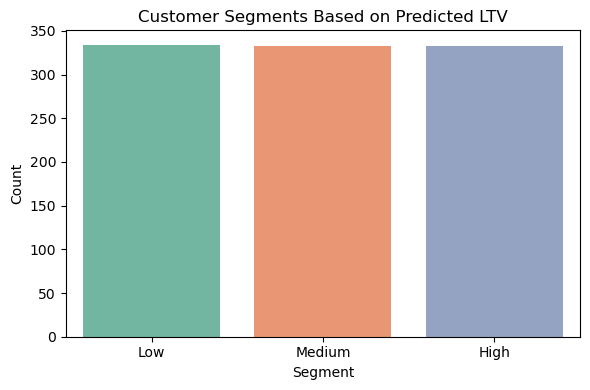

In [39]:
# Visualize Segments
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='LTVSegment', palette='Set2')
plt.title("Customer Segments Based on Predicted LTV")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

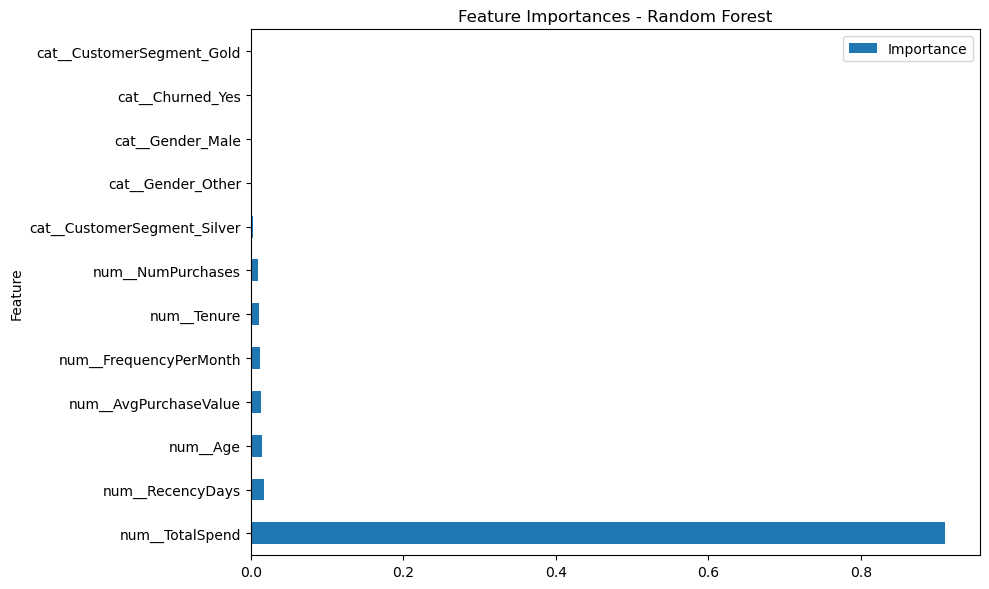

In [40]:
importances = rf_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df.sort_values(by='Importance', ascending=False).plot(kind='barh', x='Feature', figsize=(10, 6))
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


C:\Users\padma\AppData\Local\Temp\ipykernel_13808\1907157289.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='CustomerSegment', y='PredictedLTV', palette='Set2')


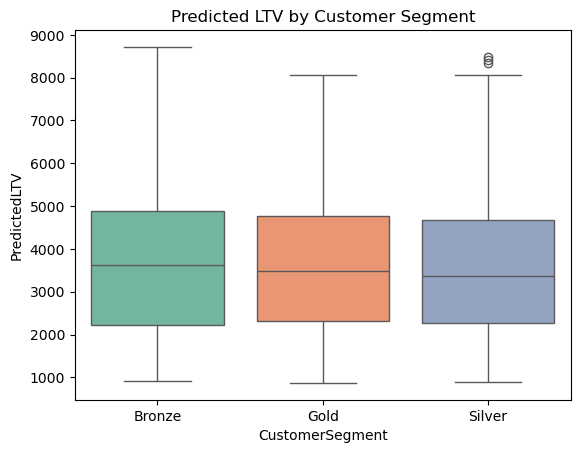

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot 1: Boxplot
sns.boxplot(data=df, x='CustomerSegment', y='PredictedLTV', palette='Set2')
plt.title("Predicted LTV by Customer Segment")
plt.show()


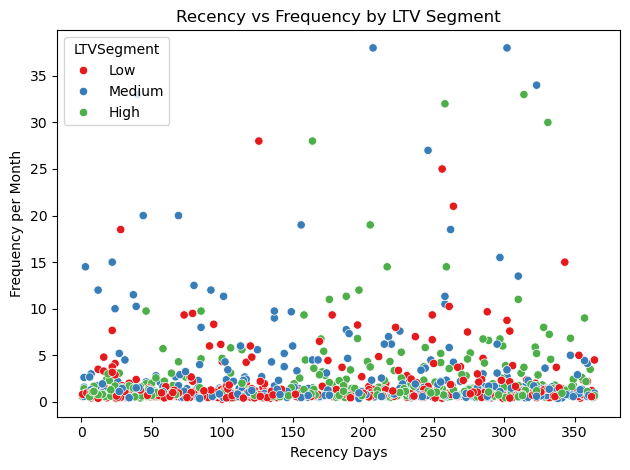

In [42]:
sns.scatterplot(data=df, x='RecencyDays', y='FrequencyPerMonth', hue='LTVSegment', palette='Set1')
plt.title("Recency vs Frequency by LTV Segment")
plt.xlabel("Recency Days")
plt.ylabel("Frequency per Month")
plt.tight_layout()
plt.show()


C:\Users\padma\AppData\Local\Temp\ipykernel_13808\1930025615.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Gender', y='PredictedLTV', hue='Churned', ci=None, palette='muted')


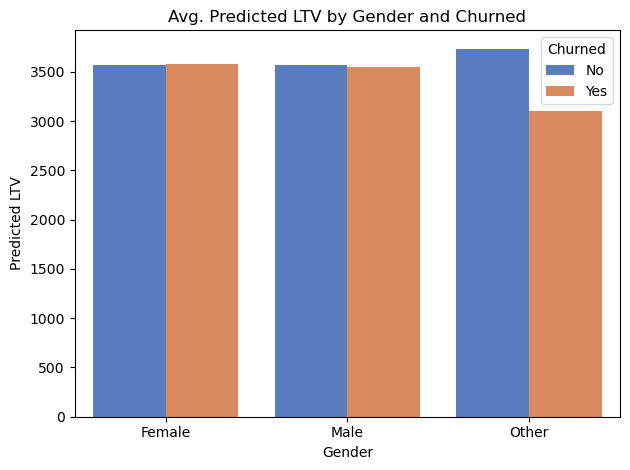

In [43]:
sns.barplot(data=df, x='Gender', y='PredictedLTV', hue='Churned', ci=None, palette='muted')
plt.title("Avg. Predicted LTV by Gender and Churned")
plt.xlabel("Gender")
plt.ylabel("Predicted LTV")
plt.tight_layout()
plt.show()


In [44]:
#Export Final Predictions
import pandas as pd
import joblib
df = pd.read_csv("C:\\Project\\Customer_Lifetime_Value_Prediction.csv")
df['PredictedLTV'] = [1000] * len(df)
df['PredictedLTV'] = rf_model.predict(X_processed)
df['LTVSegment'] = pd.qcut(df['PredictedLTV'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')


In [45]:
# Export to CSV
output_columns = ['CustomerID', 'PredictedLTV', 'LTVSegment']
df[output_columns].to_csv("C:\\Project\\final_ltv_predictions.csv", index=False)
print("✅ Saved predictions to 'C:\\Project\\final_ltv_predictions.csv'")

✅ Saved predictions to 'C:\Project\final_ltv_predictions.csv'
